# Housing Market Price Prediction

![](https://miro.medium.com/max/402/1*2foyXif7hwkO8wWB5T9KtQ.png)

Задача - построить алгоритм, предсказывающий стоимость недвижимости в Москве в зависимости от характеристик жилья и макроэкономических параметров.

Почему это соревнование в качестве проекта:

1. Корявые входные данные (все как в жизни)
2. Задача как на работе, только еще и не платят деньги
3. Неанонимизированные данные - хотел придумывать фичи. Увидим, что из этого получится  ¯\_(ツ)_/¯

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_squared_log_error

In [ ]:
zf_train = zipfile.ZipFile('/kaggle/input/sberbank-russian-housing-market/train.csv.zip') 
df_train = pd.read_csv(zf_train.open('train.csv'))

zf_test = zipfile.ZipFile('/kaggle/input/sberbank-russian-housing-market/test.csv.zip') 
df_test = pd.read_csv(zf_test.open('test.csv'))

zf_submit = zipfile.ZipFile('/kaggle/input/sberbank-russian-housing-market/sample_submission.csv.zip') 
sample_submit = pd.read_csv(zf_submit.open('sample_submission.csv'))

zf_macro = zipfile.ZipFile('/kaggle/input/sberbank-russian-housing-market/macro.csv.zip') 
df_macro = pd.read_csv(zf_macro.open('macro.csv'))

print("Train dataset shape:", df_train.shape)
print("Test dataset shape:", df_test.shape)

In [ ]:
data_dict = open('/kaggle/input/sberbank-russian-housing-market/data_dictionary.txt', 'r')
data_dict.read().split('\n')

In [ ]:
df_train['price_doc'].describe()

Целевая переменная $price_doc$ - непрерывна, соответственно имеем задачу регрессии.

Метрика качества - **Root Mean Squared Logarithmic Error (RMSLE)**. Особенности:
1. Устойчива к выбросам
2. Больше штрафует за недопрогноз, чем перепрогноз
3. Добрые люди запилили ее в sklearn (но только без np.sqrt)


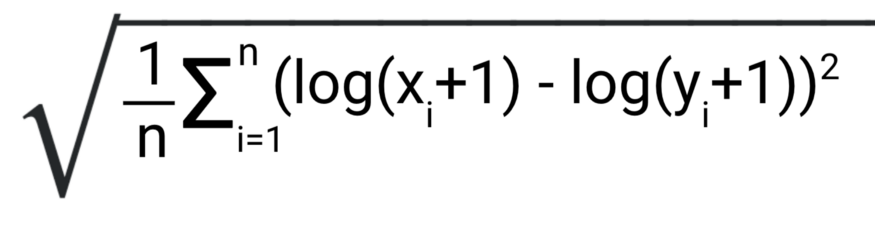

> # Анализ целевой переменной

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(df_train['price_doc'].values, bins=100, kde=True, ax=ax)
plt.title('Целевая переменная price_doc', fontsize=18)
plt.xlabel('price_doc', fontsize=12)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(np.log(df_train['price_doc']).values, bins=100, kde=True, ax=ax)
plt.title('Log(price_doc)', fontsize=18)
plt.xlabel('Log(price_doc)', fontsize=12)
plt.show()

In [ ]:
df_train['price_doc_log'] = np.log(df_train['price_doc'])

# Анализ пропусков в данных

In [ ]:
missingValueCols = df_train.columns[df_train.isnull().any()].tolist()

pd.isnull(df_train[missingValueCols]).sum().sort_values(ascending=False) / len (df_train)

Посмотрим, что из себя представляют атрибуты с пропусками:

In [ ]:
nr_rows = 17
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(15,60))
   
for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        i_col = missingValueCols[i]
        sns.distplot(df_train[df_train[i_col].notna()][i_col], bins=30, kde=False, ax = axs[r][c])
    
fig.suptitle('Распределения для признаков с пропусками', y=1.01, fontsize=18)        
plt.tight_layout()    
plt.show()

Меня заинтересовали - life_sq, build_year, kitch_sq 

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax = sns.countplot(x='build_year',data=df_train)
plt.title('build_year', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
df_train[(df_train['build_year'] > 2020) | (df_train['build_year'] < 1000) ]['build_year'].sort_values(ascending=False).value_counts()

In [ ]:
df_train['build_year'] = df_train['build_year'].replace({20052009: 2007, 0 : 2000, 1 : 2001, 3 : 2003, 20 : 1920, 71 : 1971,
                                4965 : df_train['build_year'].mode().iloc[0],
                                215 : df_train['build_year'].mode().iloc[0]})

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax = sns.countplot(x='build_year',data=df_train)
plt.title('build_year (пофиксили ошибки в данных)', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,30))
sns.boxplot(x='price_doc', y='build_year', data=df_train, orient='h', ax=ax)
plt.title('Зависимость price_doc от build_year', fontsize=18)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(y='price_doc', x='life_sq', alpha=0.2, data=df_train)
ax[0].set_title('life_sq', fontsize=18)
ax[0].set_xlim([0,1000])
ax[0].set_ylim([0,100000000])

ax[1].scatter(y='price_doc', x='life_sq', alpha=0.2, data=df_train)
ax[1].set_title('life_sq без выбросов', fontsize=18)
ax[1].set_xlim([0,125])
ax[1].set_ylim([0,30000000])
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(y='price_doc', x='kitch_sq', alpha=0.2, data=df_train)
ax[0].set_title('kitch_sq', fontsize=18)

ax[1].scatter(y='price_doc', x='kitch_sq', alpha=0.2, data=df_train)
ax[1].set_title('kitch_sq без выбросов', fontsize=18)
ax[1].set_xlim([0,40])
plt.show()

Есть единичные выбросы - но непонятна их природа (возможно огромная kitch_sq - это про здания общепита). Пока не будем от них избавляться.

# Заполним пропуски

In [ ]:
cols_fillna_mode = ['floor',
 'product_type', 
 'build_year',                 
 'max_floor',
 'material',
 'num_room',
 'state',
 'preschool_quota',
 'school_quota',
 'hospital_beds_raion',
 'raion_build_count_with_material_info',
 'raion_build_count_with_builddate_info',
 'ID_railroad_station_walk',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_1971-1995',
 'build_count_after_1995',
 'green_part_2000']

cols_fillna_mean = ['life_sq',
 'kitch_sq',
 'metro_min_walk',
 'metro_km_walk',
 'railroad_station_walk_km',
 'railroad_station_walk_min',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1000_max_price_avg',
 'cafe_avg_price_1000',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_avg_price_2000',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_avg_price_3000',
 'prom_part_5000',
 'cafe_sum_5000_min_price_avg',
 'cafe_sum_5000_max_price_avg',
 'cafe_avg_price_5000']

In [ ]:
for col in cols_fillna_mode:
    df_train[col].fillna(df_train[col].mode().iloc[0],inplace=True)
    df_test[col].fillna(df_test[col].mode().iloc[0],inplace=True)
    
for col in cols_fillna_mean:
    df_train[col].fillna(df_train[col].mean(),inplace=True)
    df_test[col].fillna(df_test[col].mean(),inplace=True)
    
# for col in cols_fillna_none:
#     df_train[col].fillna('None',inplace=True)
#     df_test[col].fillna('None',inplace=True)

In [ ]:
df_train[missingValueCols].info()

# Анализ признаков

In [ ]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Начнем с категориальных признаков:

In [ ]:
for cat in categorical_feats:
    print(cat, df_train[cat].nunique())

In [ ]:
df_train['year_month'] = df_train['timestamp'].apply(lambda x: x[:4] + x[5:7]).astype(int)
df_train['year'] = df_train['timestamp'].apply(lambda x: x[:4]).astype(int)
df_train['month'] = df_train['timestamp'].apply(lambda x: x[5:7]).astype(int)
# df_train['month_day'] = df_train['timestamp'].apply(lambda x: x[5:7] + x[8:]).astype(int)

df_test['year_month'] = df_test['timestamp'].apply(lambda x: x[:4] + x[5:7]).astype(int)
df_test['year'] = df_test['timestamp'].apply(lambda x: x[:4]).astype(int)
df_test['month'] = df_test['timestamp'].apply(lambda x: x[5:7]).astype(int)
# df_test['month_day'] = df_test['timestamp'].apply(lambda x: x[5:7] + x[8:]).astype(int)

df_train.drop('timestamp', axis=1, inplace=True)
df_test.drop('timestamp', axis=1, inplace=True)

numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x='year_month', y='price_doc', data=df_train)
plt.title('Зависимость таргет-переменной от признака year_month', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

Заметен тренд на рост целевой переменной c увеличением даты

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='month', y='price_doc', data=df_train)
plt.title('Зависимость таргет-переменной от признака month', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

Примечательно, но во второй половине года (и особенно в октябре и ноябре) - цены ниже.

In [ ]:
nr_rows = 5
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        i_col = categorical_feats[i]
        sns.countplot(x=i_col, data=df_train,ax = axs[r][c])

fig.suptitle('Countplots для категориальных признаков', y=1.02, fontsize=18)  
plt.tight_layout()    
plt.show()
    

Большинство категориальных признаков - бинарные.

In [ ]:
cols_violin = categorical_feats.drop(['ecology', 'sub_area'], errors='ignore')

In [ ]:
nr_rows = 7
nr_cols = 2

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3,nr_rows*3))
df_train['temp'] = ''

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < 13:
            i_col = cols_violin[i]
            sns.violinplot(y='price_doc_log', x='temp', hue=i_col, bw=0.2, split=True, data=df_train, ax = axs[r][c])
        
#         sns.countplot(x=i_col, data=df_train,ax = axs[r][c])
#         sns.boxplot(data=df_train, y=df_train[categorical_feats[i]],x="price_doc_log", orient='h', ax = axs[r][c])
#         sns.distplot(df_train[df_train[i_col].notna()][i_col], bins=30, kde=False, ax = axs[r][c])

fig.suptitle('Зависимость таргет-переменной от категориальных признаков', y=1.02, fontsize=18)  
plt.tight_layout()    
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
ax = sns.violinplot(x='ecology', y='price_doc_log', bw=.05, data=df_train)
plt.title('Зависимость таргет-переменной от признака ecology', fontsize=18)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,30))
sns.barplot(y='sub_area', x='price_doc', data=df_train, orient='h')
plt.title('Зависимость таргет-переменной от признака sub-area', fontsize=18)
plt.show()

In [ ]:
df_train.drop(['temp', 'id', 'price_doc'], axis=1, inplace=True)
id_test = df_test['id']
df_test.drop(['id'], axis=1, inplace=True)

# Кодирование категориальных признаков

In [ ]:
categorical_feats

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='error')
ohe_cols_train = pd.DataFrame(ohe.fit_transform(df_train[categorical_feats]).toarray())
ohe_cols_test = pd.DataFrame(ohe.transform(df_test[categorical_feats]).toarray())

# не знаю как вы, а я не могу без родных названий
ohe_cols_train.columns = ohe.get_feature_names(categorical_feats)
ohe_cols_test.columns = ohe.get_feature_names(categorical_feats)

# вернем индексы, их забрали и не спросили
ohe_cols_train.index = df_train.index
ohe_cols_test.index = df_test.index

# категориальные фичи сделали свое дело, категориальные фичи могут уходить
num_df_train = df_train.drop(categorical_feats, axis=1)
num_df_test = df_test.drop(categorical_feats, axis=1)

# собираем датасеты
df_train_ohe = pd.concat([num_df_train, ohe_cols_train], axis=1)
df_test_ohe = pd.concat([num_df_test, ohe_cols_test], axis=1)

print("Train dataset shape:", df_train_ohe.shape)
print("Test dataset shape:", df_test_ohe.shape)

# Масштабирование признаков

In [ ]:
df_train_ohe.median().sort_values(ascending=False)

Значения атрибутов отличаются на порядки, нам потребуется масштабирование. Но для начала отделим целевую переменную.

In [ ]:
y = df_train_ohe['price_doc_log']
X = df_train_ohe.drop(['price_doc_log'], axis=1)

print("X shape:", X.shape)
print("y shape:", y.shape)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

x_sc = StandardScaler()
X_train_scaled = pd.DataFrame(x_sc.fit_transform(X_train), columns=X_train.columns)
X_valid_scaled = pd.DataFrame(x_sc.transform(X_valid), columns=X_valid.columns)

# Обычная Линейная регрессия

In [ ]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
lin_predictions_log = linreg.predict(X_valid_scaled)
lin_predictions = np.exp(lin_predictions_log)

In [ ]:
print('RMSLE linear regression (valid dataset):', np.sqrt(mean_squared_log_error(np.exp(y_valid), lin_predictions)))

# Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor  
  
tree = DecisionTreeRegressor(random_state = 42, max_depth=7, min_samples_split=20)  
tree.fit(X_train_scaled, y_train)

tree_predictions_log = tree.predict(X_valid_scaled)
tree_predictions = np.exp(tree_predictions_log)

In [ ]:
print('RMSLE Decision Tree (valid dataset):', np.sqrt(mean_squared_log_error(np.exp(y_valid), tree_predictions)))

# Boosting

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [ ]:
xgb_train = xgb.DMatrix(X_train_scaled, y_train)
xgb_valid = xgb.DMatrix(X_valid_scaled)

xgb_model = xgb.XGBRegressor(seed=42)

parameters = {'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07],
#               'learning_rate': [0.05],
              'max_depth': [5, 7],
#               'max_depth': [5],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb_model,
                        parameters,
                        cv = 2,
                        n_jobs = -1,
                        verbose=True)

In [ ]:
xgb_grid.fit(X_train_scaled, y_train)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
xgb_grid.best_estimator_

In [ ]:
xgb_predictions_log = xgb_grid.best_estimator_.predict(X_valid_scaled)
xgb_predictions = np.exp(xgb_predictions_log)

In [ ]:
print('RMSLE XGB (valid dataset):', np.sqrt(mean_squared_log_error(np.exp(y_valid), xgb_predictions)))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
_= xgb.plot_importance(xgb_grid.best_estimator_, max_num_features=30, height=0.5, ax=ax)

In [ ]:
# df_test_scaled = pd.DataFrame(x_sc.transform(df_test_ohe), columns=df_test_ohe.columns)

In [ ]:
# xgb_pred_test_log = xgb_model.predict(df_test_scaled)
# xgb_pred_test = np.exp(xgb_predictions_log)

# ylog_pred = xgb_model.predict(df_test_scaled)
# y_pred = np.exp(ylog_pred)

# df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

# df_sub.to_csv('sub.csv', index=False)

# The End

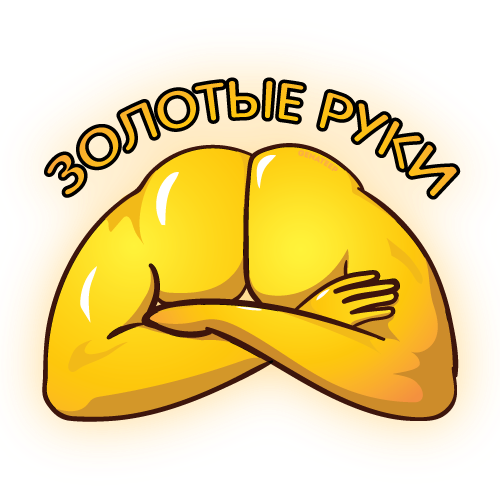